In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/clear_cloudy_merged/train_A_over_ganaug_050"
plot_title = "train_A_over_ganaug_050"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.877979,0.878,0.730337,0.878,0.731105,0.967786,0.922155,0.945188,0.801122,0.613680
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.894569,0.891,0.770689,0.891,0.801812,0.972375,0.948220,0.952185,0.850307,0.678234
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.905695,0.903,0.794817,0.903,0.822730,0.975726,0.956890,0.957003,0.869581,0.710763
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.913480,0.912,0.814218,0.912,0.832898,0.980054,0.960934,0.964600,0.878687,0.731439
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.909484,0.907,0.808845,0.907,0.836915,0.978612,0.962718,0.961255,0.882353,0.722710


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.828857,0.8140,0.627190,0.8140,0.671240,0.939155,0.875392,0.898515,0.696188,0.464054
1,2,test,0.849774,0.8365,0.674627,0.8365,0.726132,0.948994,0.904704,0.913540,0.765594,0.530868
2,3,test,0.861538,0.8505,0.701058,0.8505,0.759755,0.956158,0.918009,0.925034,0.795369,0.570492
3,4,test,0.874451,0.8655,0.723676,0.8655,0.771762,0.961407,0.922090,0.933789,0.807753,0.601146
4,5,test,0.876559,0.8685,0.728263,0.8685,0.782830,0.963589,0.924577,0.937720,0.817354,0.612264


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/399:,Train,Loss,=,1.521,Valid,Loss,=,1.575,ETA,=,6.79h
1,Epoch,"1/40,",Batch,20/399:,Train,Loss,=,1.517,Valid,Loss,=,1.529,ETA,=,6.35h
2,Epoch,"1/40,",Batch,30/399:,Train,Loss,=,1.481,Valid,Loss,=,1.464,ETA,=,5.22h
3,Epoch,"1/40,",Batch,40/399:,Train,Loss,=,1.460,Valid,Loss,=,1.452,ETA,=,5.36h
4,Epoch,"1/40,",Batch,50/399:,Train,Loss,=,1.422,Valid,Loss,=,1.389,ETA,=,5.17h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.521,1.575
20,1,20,1.517,1.529
30,1,30,1.481,1.464
40,1,40,1.460,1.452
50,1,50,1.422,1.389


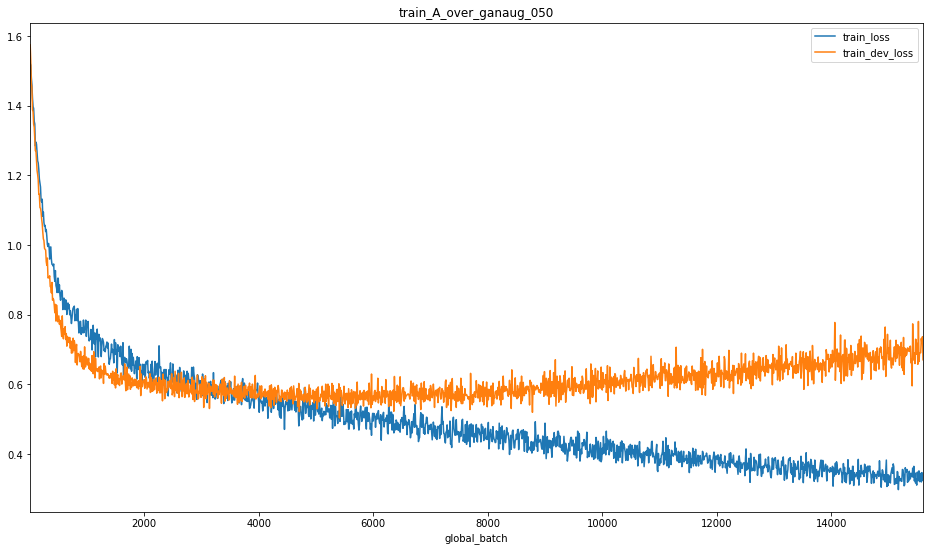

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.132,1.095
2,0.842,0.746
3,0.755,0.663
4,0.703,0.629
5,0.662,0.611


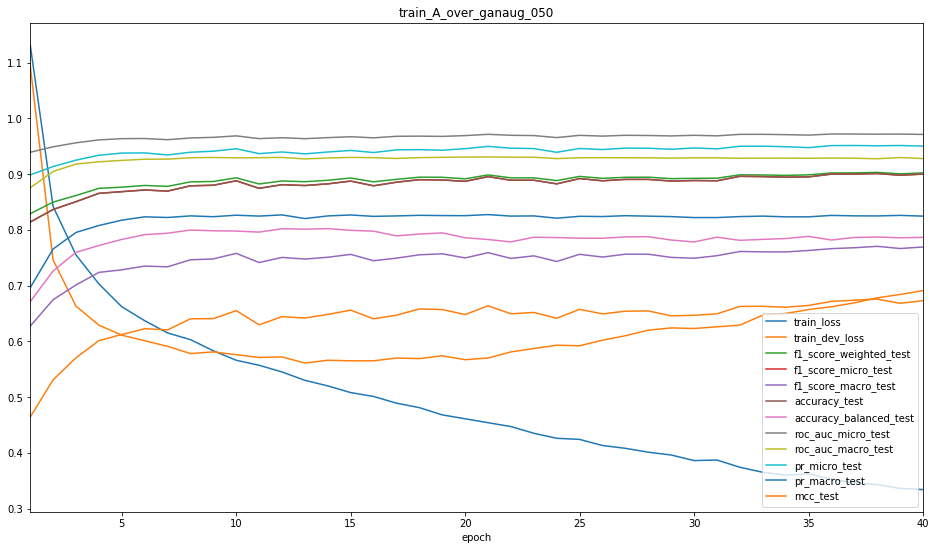

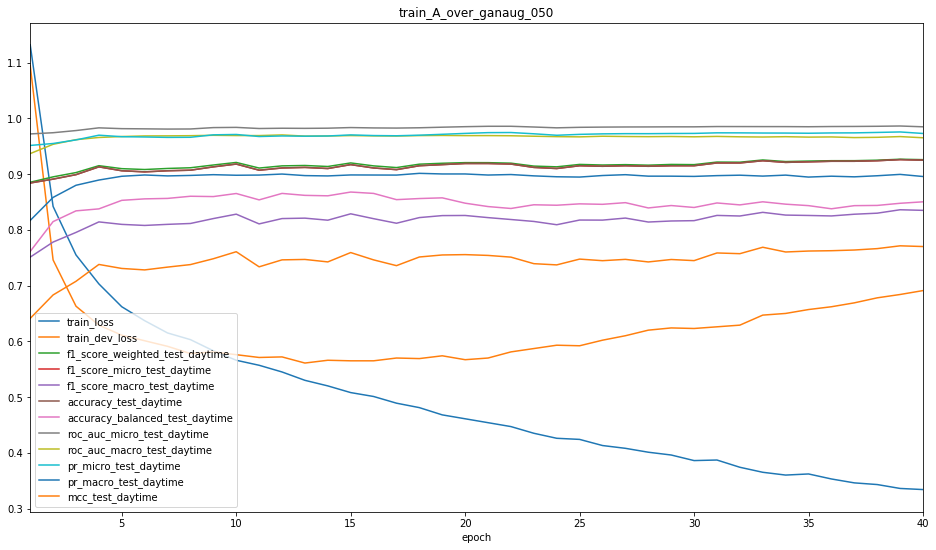

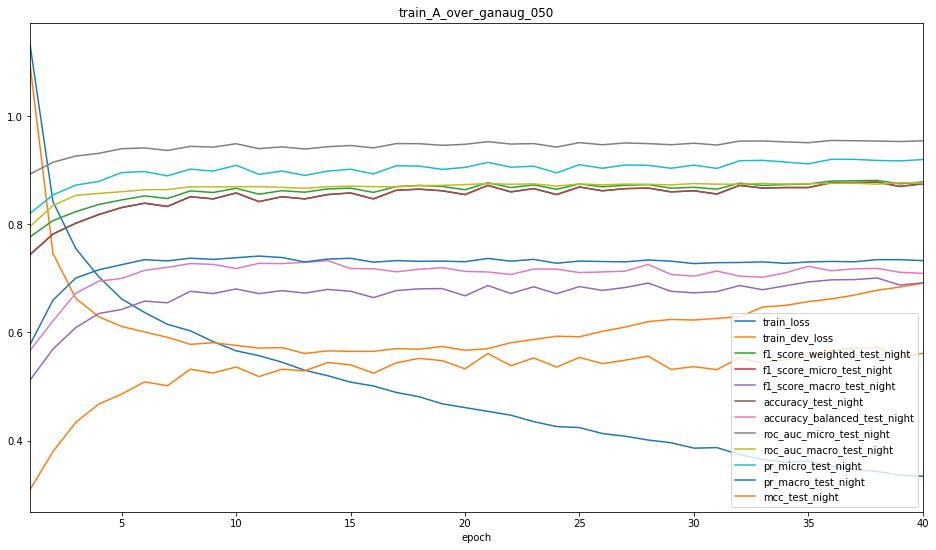

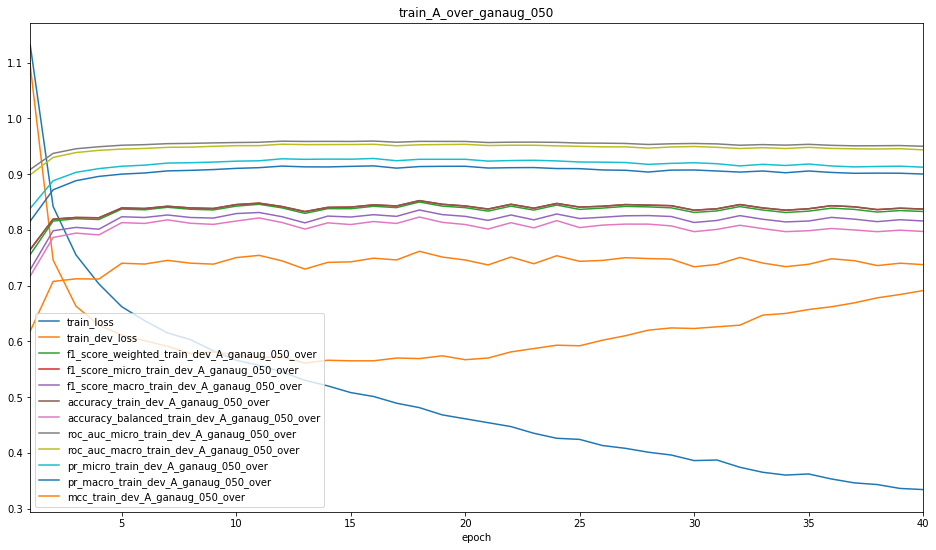

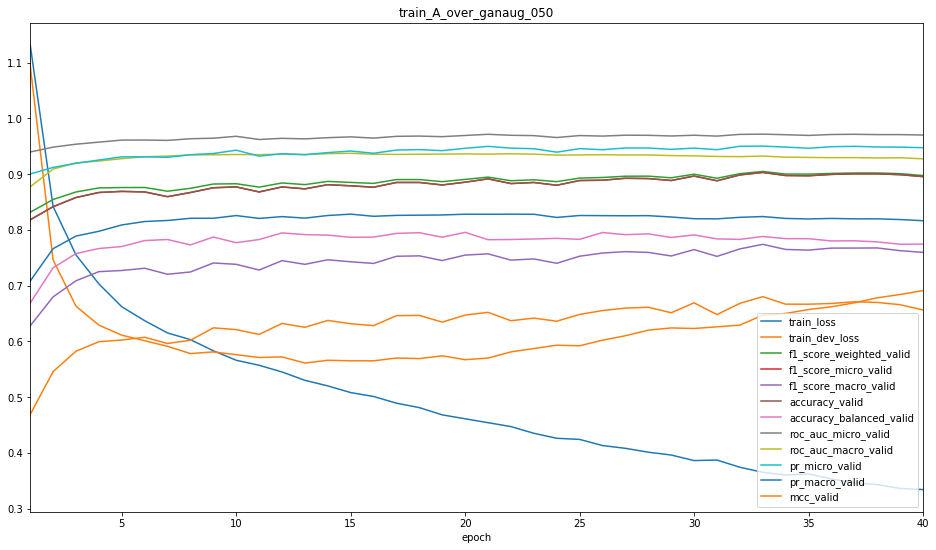

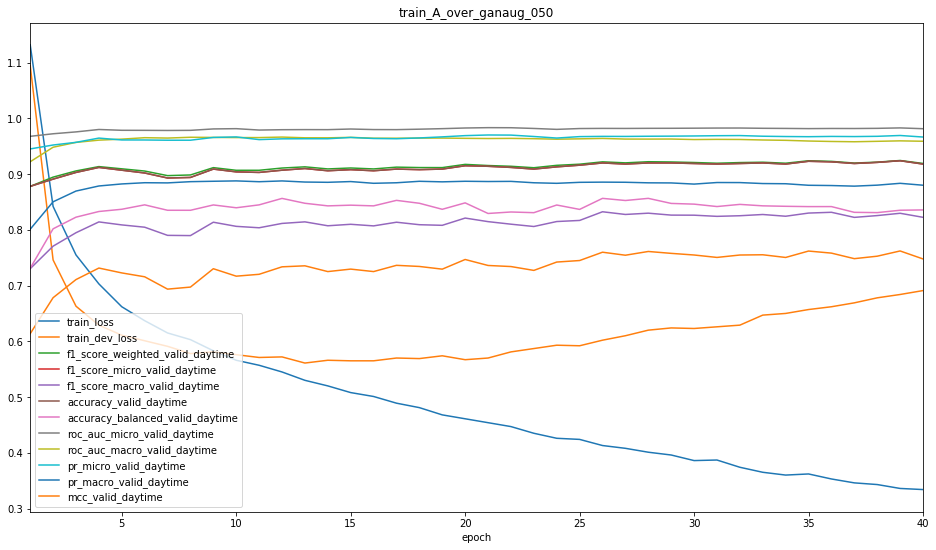

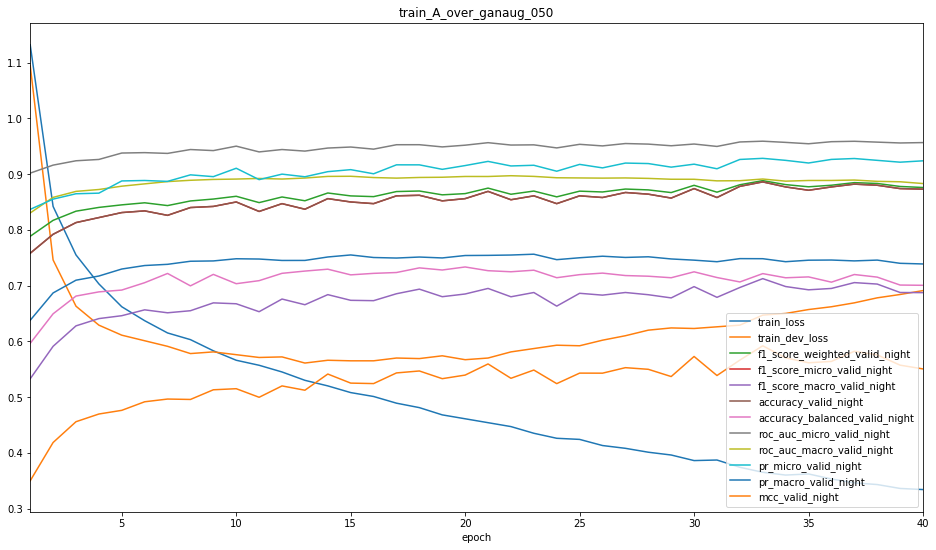

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)